by Maciej Marcinkiewicz (300171) and Katarzyna Bielecka (300165)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import  KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim

# Data preprocessing

## Data loading and preview

In [2]:
df = pd.read_csv("Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


 We start from removing the ID column as it is not providing any information which could help with species prediction - it is helpful only
 from the organizational point of view for the data owner/maintainer.

In [3]:
df = df.drop(["Id"], axis=1)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Categorical data encoding and selection of data to be predicted

We want to predict species of Iris based on parameters. Below we check how many species we have - they will define our classes in the classification problem.

In [5]:
labels = df.Species.unique()

As stated above, we will predict the species. Thus we assign it to Y and encode it with values 0-2. To X we assign the rest of data. 

In [6]:
X = df.drop(["Species"], axis=1).values
Y = df.Species.map(lambda x: np.where(labels == x)[0][0]).values

In order to use data in pytorch functions we need to convert it into tensor form, as below. Also a type change was needed as methods accepted float type, and initially the type was double. 

In [7]:
X_tensor = torch.from_numpy(X).type(torch.FloatTensor)
Y_tensor = torch.from_numpy(Y).type(torch.LongTensor)

# Model and functions definition

## Model

Below we defined a sequential neural network model with 4 layers total: the input layer, two hidden layers and the output layer. We chose arbitrary numbers for the number of neurons. As the activation function, we chose a rather popular one - the ReLu (Rectified Linear Unit) function. What is worth mentioning we also tried using the sigmoid function instead, just to compare but the results were significantly worse - that is why we ended up choosing ReLu.

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.linear_stack(x)

## Functions for the training and evaluation process

### Training function

In [9]:
def train(model, X_train, y_train, loss_func, num_of_epochs, optimizer):
    train_loss, train_accuracy = [], []

    for epoch in range(num_of_epochs):
        optimizer.zero_grad()

        output = model(X_train)
        y_pred = output.argmax(1)

        loss = loss_func(output, y_train)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        acc = accuracy_score(y_pred=y_pred, y_true=y_train)
        train_accuracy.append(acc)

    return train_loss, train_accuracy

### Metrics and plots functions

In [10]:
def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    print(f"Accuracy: {acc}\nMacro precision: {prec}\nMacro recall: {recall}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="")
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

In [11]:
def linear_plot(epochs, y, title, ylabel):
    x = list(range(1, epochs + 1))
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.show()

### Model evalation function

Below, a function for kfold evaluation is implemented. We used a built-in Stochastic Gradient Descent optimization ffunction for training. Moreover, parameters for the Neural Networks are fixed as they will not change - we have 4 dimensions for input - 4 parameteters describing the properties of Iris species, and 3 outputs - for probabibilities of each species. 

In [15]:
def kfold_evalution(params_dict):
    kf = KFold(n_splits = params_dict["cv"], shuffle=True)

    for fold, (train_idx, test_idx) in enumerate(kf.split(params_dict["X"])):
        print(f"Fold {fold + 1}")    
        X_train, X_test = params_dict["X"][train_idx], params_dict["X"][test_idx]
        y_train, y_test = params_dict["Y"][train_idx], params_dict["Y"][test_idx]

        model = NeuralNetwork(input_dim=4, output_dim=3).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01)

        train_loss, train_accuracy = train(model, X_train, y_train, params_dict["loss_func"], params_dict["epochs"], optimizer)

        linear_plot(params_dict["epochs"], train_loss, "Loss function values", "loss function")
        linear_plot(params_dict["epochs"], train_accuracy, "Training accuracies", "accuracy")

        with torch.no_grad():
            y_pred_test = model(X_test).argmax(1)

        metrics(y_test, y_pred_test)

# Evaluation

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Cross entropy loss function

First version of the model we test is one defined with cross entropy loss function. It is a commonly used function for multi-class classification problems. 

In [16]:
params = {
    "loss_func": nn.CrossEntropyLoss(),
    "X": X_tensor,
    "Y": Y_tensor,
    "cv": 5,
    "epochs": 200
}

Fold 1


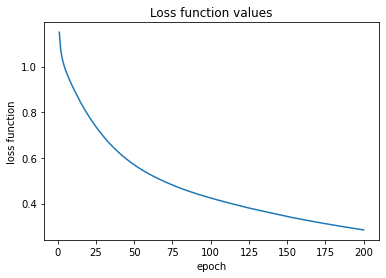

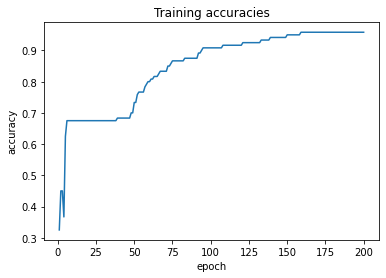

Accuracy: 1.0
Macro precision: 1.0
Macro recall: 1.0


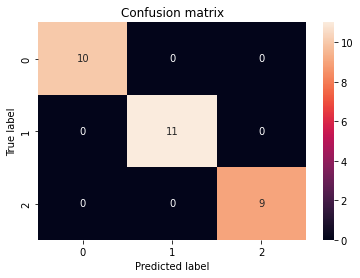

Fold 2


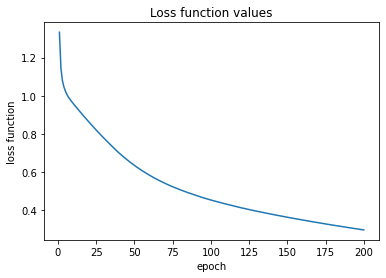

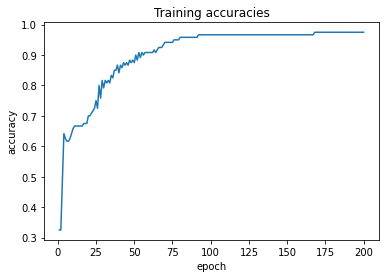

Accuracy: 1.0
Macro precision: 1.0
Macro recall: 1.0


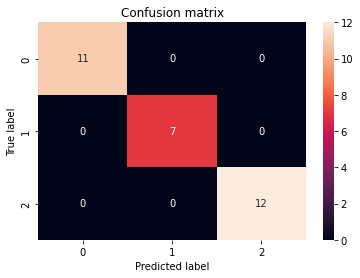

Fold 3


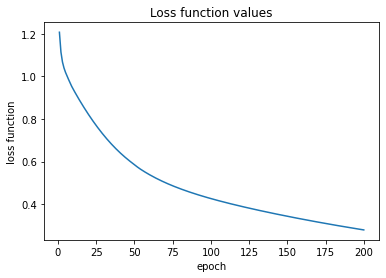

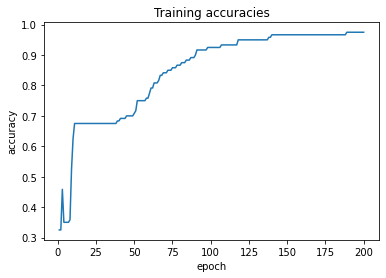

Accuracy: 0.9666666666666667
Macro precision: 0.9629629629629629
Macro recall: 0.9696969696969697


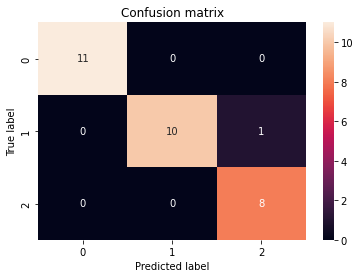

Fold 4


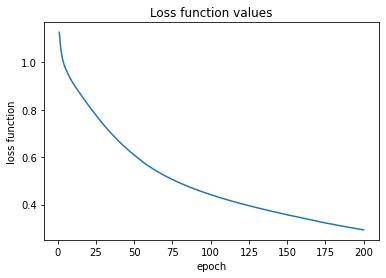

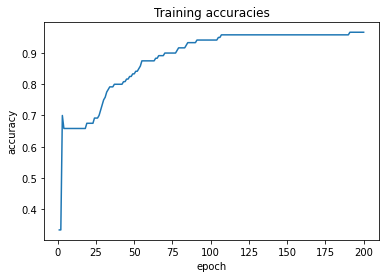

Accuracy: 1.0
Macro precision: 1.0
Macro recall: 1.0


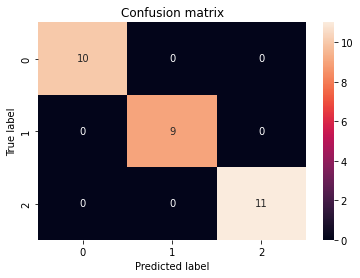

Fold 5


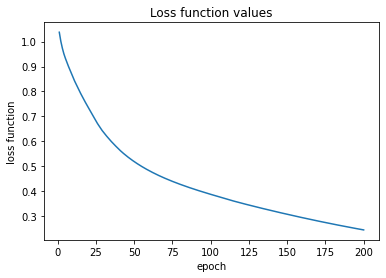

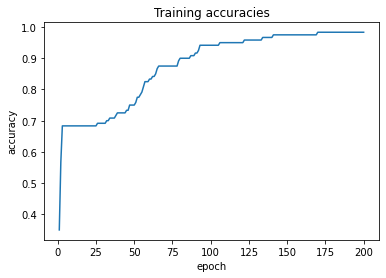

Accuracy: 0.9
Macro precision: 0.923076923076923
Macro recall: 0.9166666666666666


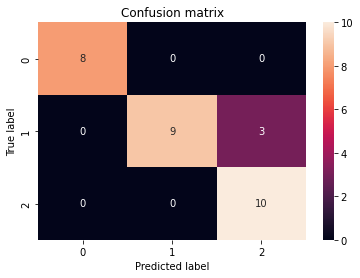

In [17]:
kfold_evalution(params)

As we can see accuracy obtained by the model is very high across all folds - ranging from 1 at most to 0.9 at worst. All the other metrics are very good as well. It is possible that due to a rather small dataset we were able to achieve such good results with just two (hidden) layers. 

## Margin-based loss function

In [24]:
params = {
    "loss_func": nn.MultiMarginLoss(),
    "X": X_tensor,
    "Y": Y_tensor,
    "cv": 5,
    "epochs": 200
}

Fold 1


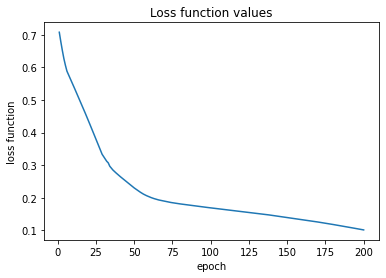

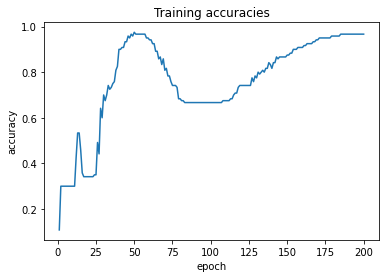

Accuracy: 0.9666666666666667
Macro precision: 0.9777777777777779
Macro recall: 0.9629629629629629


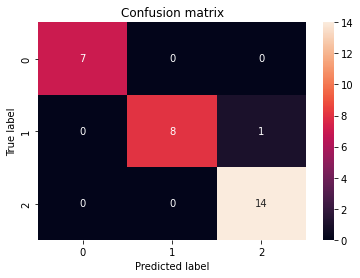

Fold 2


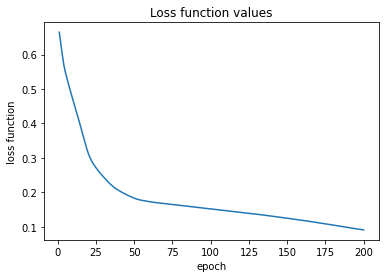

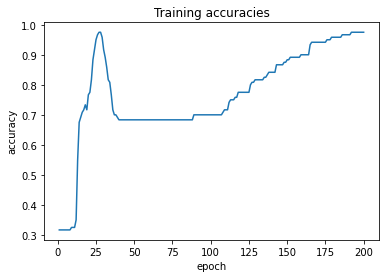

Accuracy: 0.9333333333333333
Macro precision: 0.9487179487179488
Macro recall: 0.9444444444444445


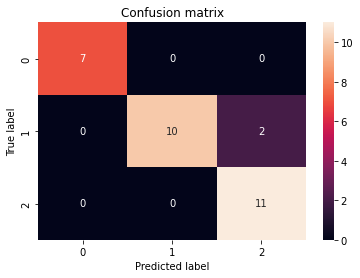

Fold 3


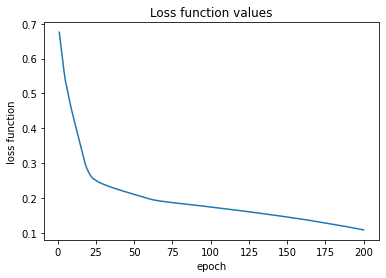

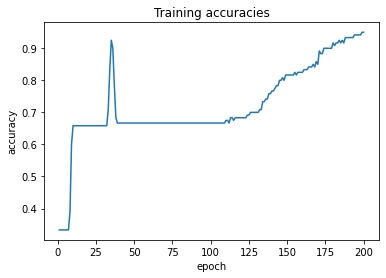

Accuracy: 1.0
Macro precision: 1.0
Macro recall: 1.0


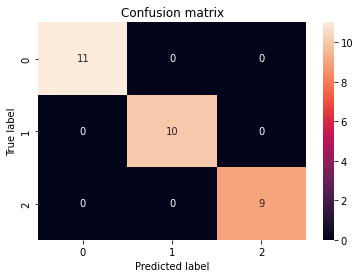

Fold 4


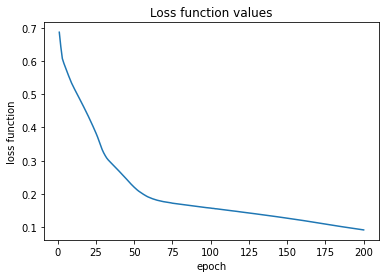

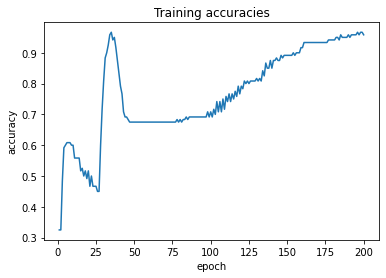

Accuracy: 0.9666666666666667
Macro precision: 0.9666666666666667
Macro recall: 0.9696969696969697


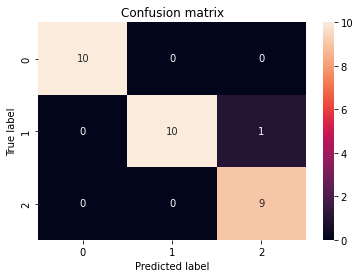

Fold 5


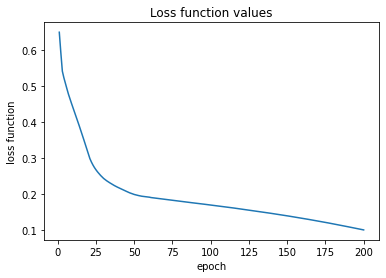

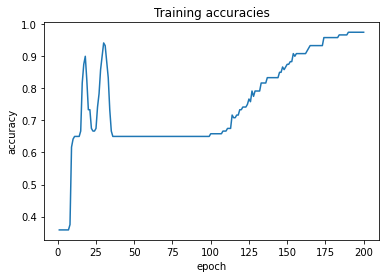

Accuracy: 0.9666666666666667
Macro precision: 0.9583333333333334
Macro recall: 0.9583333333333334


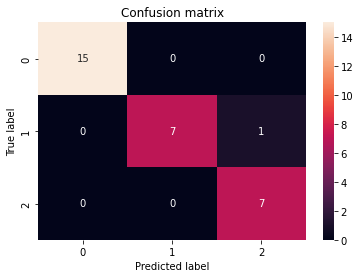

In [25]:
kfold_evalution(params)

As one can notice application of margin-based loss yielded similiarly good results as the previosly used loss function. With accuracy ranging from 0.93 to 1. Though, it is worth noting that it took more training time for this method to arrive at such good accuracy. We may notice that the cross entropy loss attempt reached good accuracy within less number of epochs. Thus, we may conclude that it is faster, at least in our case. 